<a href="https://colab.research.google.com/github/hoaithanh2506/Customer-Segmentation-using-RFM-analysis/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plan

---
Before we get into the process, I will give you a brief on what kind of steps we will get.

Reading data and preprocessing

Create Recency Frequency Monetary (RFM) table

Model - Clustering with K-means algorithm

Interpret the result

In [ ]:
import sys
import pandas as pd
import numpy as np
import plotly.express as px
import plotly as py
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from PIL import Image

import pandas as pd
from pathlib import Path

import calendar
!pip install termcolor
from termcolor import colored
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

Step 1 Reading data and preprocessing

In [ ]:

import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
PATH = "/content/drive/MyDrive/cty/online_retail_II.csv"
df= pd.read_csv(PATH)
#df= pd.read_excel("online_retail_II.xlsx")
df.head(5)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [ ]:
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])


Number of rows in dataset is:  1067371
Number of columns in dataset is:  8


# Wrangle, prepare, cleanse the data

---- Start the data cleaning----
We need to make sure the data is clean before starting your analysis. As a reminder, we should check for:

Duplicate records

Consistent formatting

Missing values (Remove the canceled order)

Obviously wrong values (Remove the transaction with negative quantity)

Duplicate Records

How many duplicate transaction records are there?

In [ ]:
print('Duplicate entries: {}'.format(df.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((df.duplicated().sum()/df.shape[0])*100),2))
#Remove duplicate data
df.drop_duplicates(inplace = True)


Duplicate entries: 34335
3% rows are duplicate.


# Consistent formatting

In [ ]:
df['Customer ID'] = df['Customer ID'].astype(str)

In [ ]:
df.describe()

,Quantity,Price
count,1.033036e+06,1.033036e+06
mean,1.007688e+01,4.613980e+00
std,1.751976e+02,1.223975e+02
min,-8.099500e+04,-5.359436e+04
25%,1.000000e+00,1.250000e+00
50%,3.000000e+00,2.100000e+00
75%,1.000000e+01,4.150000e+00
max,8.099500e+04,3.897000e+04


Checking the total number of products, transactions and customers.

In [ ]:


pd.DataFrame([{'products': len(df['StockCode'].value_counts()),
               'transactions': len(df['Invoice'].value_counts()),
               'customers': len(df['Customer ID'].unique().tolist()),
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])



,products,transactions,customers
quantity,5305,53628,5943


# Missing values
Removing cancelled orders from the data. Filtering transaction with invoice number started with letter 'C' and missing Customer ID.

Removing cancelled orders

In [ ]:
cancelled = df['Invoice'].astype(str).str.contains('C')
cancelled.fillna(0, inplace=True)
cancelled = cancelled.astype(int)
cancelled.value_counts()

0    1013932
1      19104
Name: Invoice, dtype: int64

In [ ]:
df['order_canceled'] = cancelled
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,order_canceled
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0


In [ ]:
n1 = df['order_canceled'].value_counts()[1]
n2 = df.shape[0]
print("Number of cancelled transactions:", n1)
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))
df = df[df['order_canceled'] == 0]

Number of cancelled transactions: 19104
Number of orders canceled: 19104/1033036 (1.85%) 


In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,order_canceled
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0


# Removing transaction with missing Customer ID
We find out that CustomerID values are missing for those customers which have negative quantity values. Therefore, we will remove them too.

In [ ]:
df = df[df['Customer ID'].notna()]

## Obviously wrong values
Remove transaction with negative values for price and quantity

In [ ]:
print("Total number of transaction with negative quantity:", df[df['Quantity'] <= 0 ]['Quantity'].count())
print("Precentage of transactions with zero or negative quantity" ,round(len(df[df['Quantity']<=0])/len(df)*100, 2),"%")
print("Total number of transaction with negative Price:", df[df['Price'] <= 0 ]['Price'].count())
print("Precentage of transactions with zero or negative price" ,round(len(df[df['Price']<=0])/len(df)*100, 2),"%")


Total number of transaction with negative quantity: 3393
Precentage of transactions with zero or negative quantity 0.33 %
Total number of transaction with negative Price: 6019
Precentage of transactions with zero or negative price 0.59 %


In [ ]:
df = df[(df['Price'] > 0) & (df['Quantity'] > 0)]
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])


Number of rows in dataset is:  1007913
Number of columns in dataset is:  9


---- End the data cleaning----
# Step 2 Create Recency Frequency Monetary (RFM) table
RFM is abasic customer segmentation algorithm based on their purchasing behaviour. The behaviour is identified by using only three customer data points:

1. Recency: the recency of purchase/ How many days ago was their last purchase?
2. Frequency: the frequency of purchases/ total number of purchases/How many times has the customer purchased from our store?
3. Monetary: the mean monetary value of each purchase/the amount they have spent/How much has this customer spent? Again limit to last two years – or take all time

The RFM Analysis will help the businesses to segment their customer base into different homogenous groups so that they can engage with each group with different targeted marketing strategies. Sometime RMF is also used to identify the High-Value Customers (HVCs).

In [ ]:
print('Start date:' , df['InvoiceDate'].min())
print('End date:' , df['InvoiceDate'].max())


Start date: 2009-12-01 07:45:00
End date: 2011-12-09 12:50:00


In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"] = df["InvoiceDate"].dt.date


In [ ]:
import datetime as dt
snapshot_date = max(df.InvoiceDate) + dt.timedelta(days=1)

In [ ]:
# RFM table
# Aggregate data by each customer
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days, 'Invoice': lambda x: len(x), 'Revenue': lambda x: x.sum()}).reset_index()
rfm['InvoiceDate'] = rfm['InvoiceDate'].astype(int)

# Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency',
                         'Invoice': 'Frequency',
                         'Revenue': 'MonetaryValue'}, inplace=True)

In [ ]:
rfm.head()


,Customer ID,Recency,Frequency,MonetaryValue
0,12346.0,326,34,77556.46
1,12347.0,3,222,4921.53
2,12348.0,76,51,2019.40
3,12349.0,19,175,4428.69
4,12350.0,311,17,334.40


Right now, the dataset consists of recency, frequency, and monetary value column. But we cannot use the dataset yet because we have to preprocess the data more.

# Manage Skewness and Scaling
We have to make sure that the data meet these assumptions:

## The data should meet assumptions where the variables are not skewed and have the same mean and variance.
Because of that, we have to manage the skewness of the variables. Here are the visualizations of each variable.

# Explore the data
## Recency, Frequency,MonetaryValue distributions

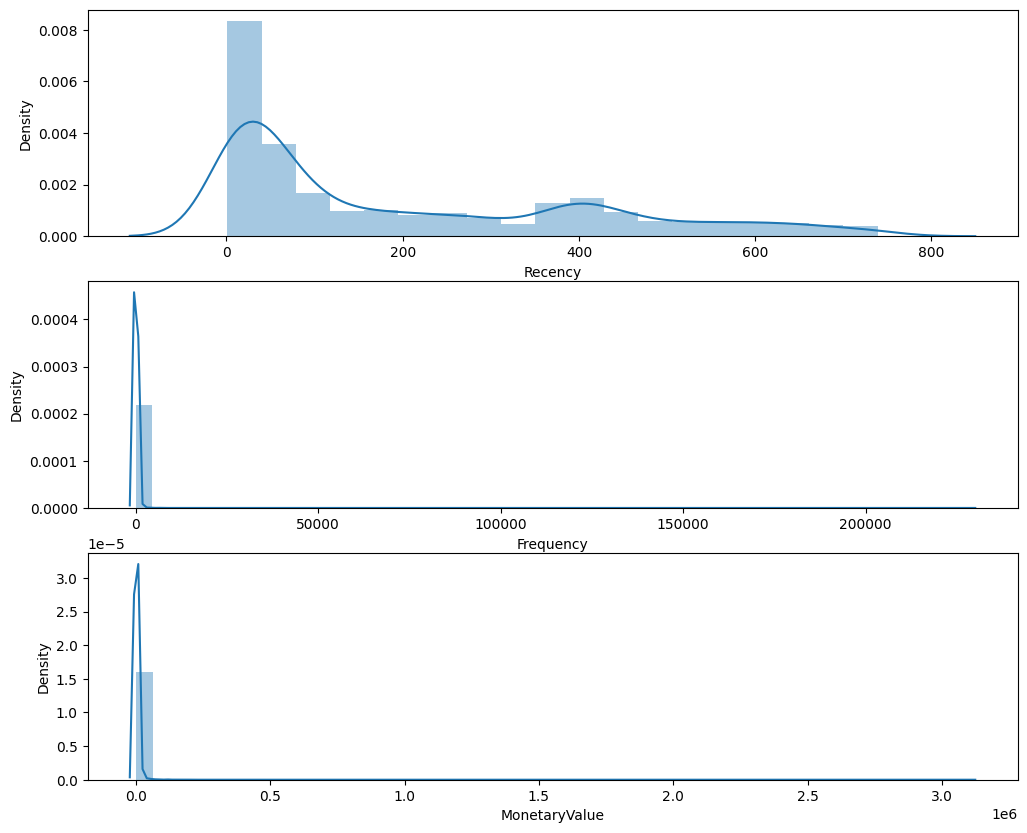

In [ ]:


plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(rfm['MonetaryValue'])

# Show the plot
plt.show()



As we can see from above, we have to transform the data, so it has a more symmetrical form. There are some methods that we can use to manage the skewness:

- log transformation
- Square root transformation
- Box-cox transformation Note: We can use the transformation if and only if the variable only has positive values



In [ ]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(rfm[x], ax=ax[0,0])
    sns.distplot(np.log(rfm[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(rfm[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()

#     print(rfm[x].skew().round(2))
#     print(np.log(rfm[x]).skew().round(2))
#     print(np.sqrt(rfm[x]).skew().round(2))
#     print(pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

    print('Log Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.log(rfm[x]).skew().round(2))
    print('Square Root Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.sqrt(rfm[x]).skew().round(2))
    print('Box-Cox Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))


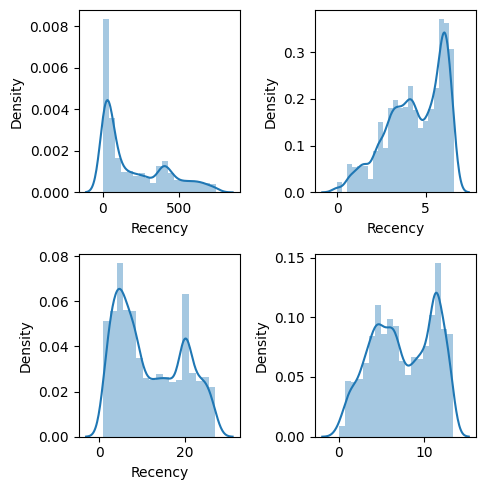

Log Transform : The skew coefficient of 0.89 to -0.55
Square Root Transform : The skew coefficient of 0.89 to 0.36
Box-Cox Transform : The skew coefficient of 0.89 to -0.12


In [ ]:
analyze_skewness('Recency')

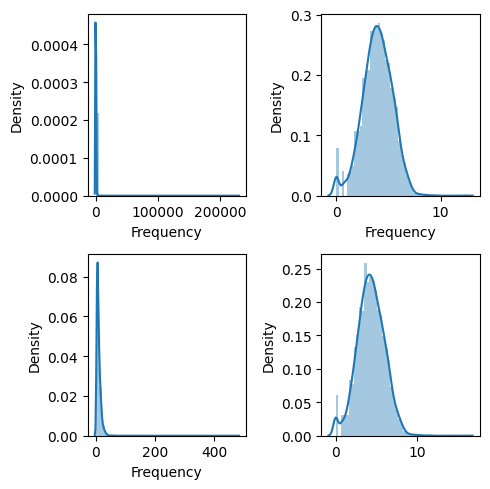

Log Transform : The skew coefficient of 75.21 to -0.2
Square Root Transform : The skew coefficient of 75.21 to 22.88
Box-Cox Transform : The skew coefficient of 75.21 to 0.01


In [ ]:
analyze_skewness('Frequency')

Based on that visualization, it shows that the variables with box-cox transformation shows a more symmetrical form rather than the other transformations. To make sure, we calculate each variable using the skew function. The result:

Recency

- Log Transform : The skew coefficient of 1.28 to -0.62

- Square Root Transform : The skew coefficient of 1.28 to 0.59

- Box-Cox Transform : The skew coefficient of 1.28 to -0.07

Frequency

- Log Transform : The skew coefficient of 64.17 to -0.27

- Square Root Transform : The skew coefficient of 64.17 to 19.51

- Box-Cox Transform : The skew coefficient of 64.17 to 0.02

Based on that calculation, we will utilize variables that use box-cox transformations. Except for the MonetaryValue variable because the variable includes negative values. To handle this variable, we can use cubic root transformation to the data.

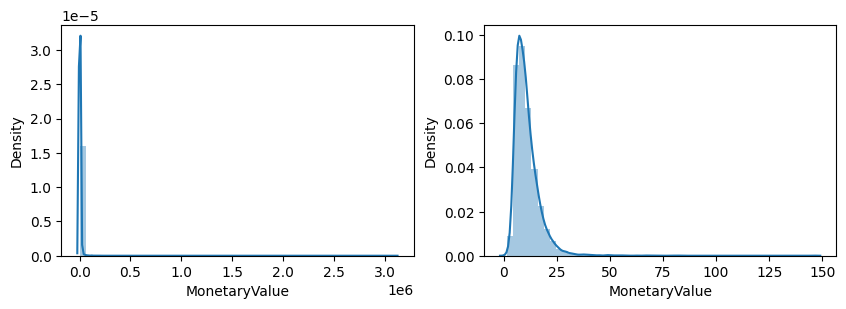

64.98
4.31


In [ ]:


fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(rfm['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(rfm['MonetaryValue']), ax=ax[1])
plt.show()
print(rfm['MonetaryValue'].skew().round(2))
print(np.cbrt(rfm['MonetaryValue']).skew().round(2))



In [ ]:
pd.Series(np.cbrt(rfm['MonetaryValue'])).values

array([ 42.64544585,  17.00983284,  12.63981693, ...,  10.90392923,
        16.1124757 , 145.83280071])

By using the transformation, we will have data that less skewed. The skewness value declines from 16.63 to 1.16. Therefore, we can transform the RFM table with this code,

In [ ]:
# Set the Numbers
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(rfm['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(rfm['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(rfm['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
5874,11.483417,3.563086,7.728829
5875,12.902671,2.611839,7.530248
5876,11.803799,4.576693,10.903929
5877,5.512618,5.584808,16.112476
5878,0.000000,15.929381,145.832801


Each variable don’t have the same mean and variance. We have to normalize it. To normalize, we can use StandardScaler object from scikit-learn library to do it. The code will look like this


In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[ 0. -0.  0.]
[1. 1. 1.]


In [ ]:
pd.DataFrame(customers_normalized).head()


,0,1,2
0,0.857094,-0.305805,5.202480
1,-1.760080,1.030482,1.005423
2,-0.218188,-0.025424,0.289965
3,-0.997384,0.855488,0.909177
4,0.817407,-0.774772,-0.643044


Finally, we can do clustering using that data.

# Step 3 Model - Clustering with K-means algorithm
To make segmentation from the data, we can use the K-Means algorithm to do this.

K-Means algorithm is an unsupervised learning algorithm that uses the geometrical principle to determine which cluster belongs to the data. By determine each centroid, we calculate the distance to each centroid. Each data belongs to a centroid if it has the smallest distance from the other. It repeats until the next total of the distance doesn’t have significant changes than before.

# Determine the Optimal K

To make our clustering reach its maximum performance, we have to determine which hyperparameter fits to the data. To determine which hyperparameter is the best for our model and data, we can use the elbow method to decide.

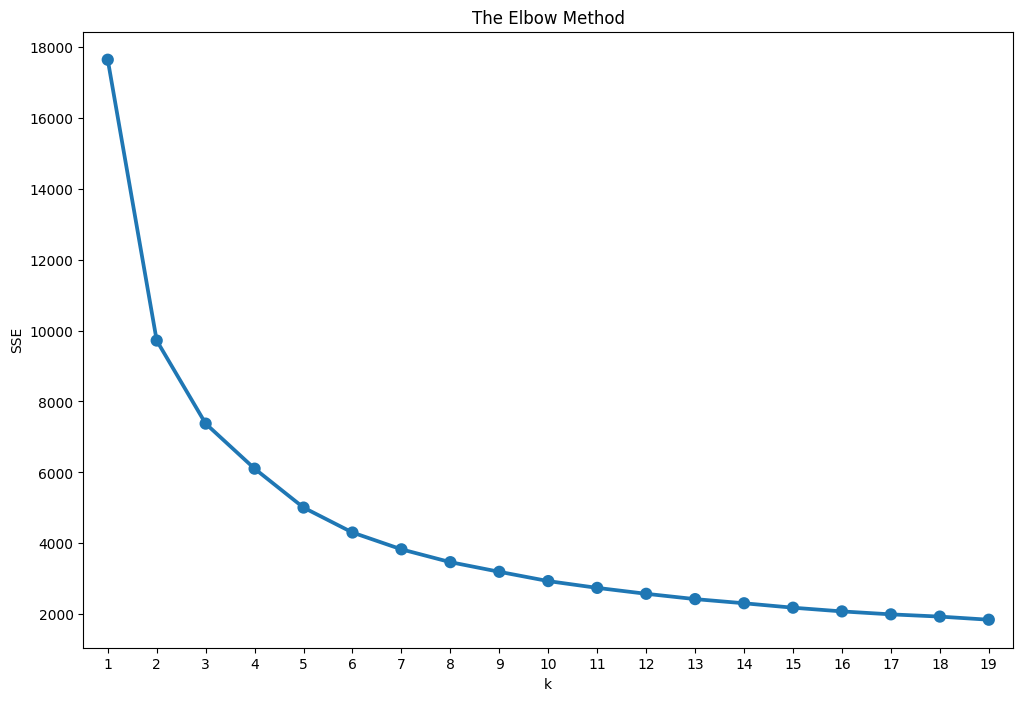

In [ ]:
plt.figure(figsize=(12,8))

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1, 20)

distortions = []
inertias = []
mapping1 = {}
sse = {}
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)

    distortions.append(sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / customers_normalized.shape[0])
    inertias.append(kmeans.inertia_)

    mapping1[k] = sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / customers_normalized.shape[0]

    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 1.4989010300892902
2 : 1.0830982839728842
3 : 0.9234080793388629
4 : 0.8313762618450372
5 : 0.7703684000002926
6 : 0.7351924837323416
7 : 0.6924079878823481
8 : 0.6589755525376072
9 : 0.6297301093787583
10 : 0.6221774298630126
11 : 0.5970881565970173
12 : 0.5855651189477364
13 : 0.5646907769635117
14 : 0.549010760988133
15 : 0.543297825378165
16 : 0.5266411234479399
17 : 0.5137539838789693
18 : 0.5081072293689524
19 : 0.4909683240644835


The x-axis is the value of the k, and the y-axis is the SSE value of the data. We will take the best parameter by looking at where the k-value will have a linear trend on the next consecutive k. From the above plot, the k-value of 3 or 4 is the best hyperparameter for our model because the next k-value tend to have a linear trend.

Let us now compare the clustering performance. For this purpose, I calculated the mean values of recency, frequency, and monetary metrics to get the following result:

# Fit the model
##Fit the model - 3 cluster

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(5879,)

In [ ]:
rfm.shape

(5879, 4)

By fitting the model, we can have clusters where each data belongs. By that, we can analyze the data.

In [ ]:
rfm["Cluster"] = model.labels_
rfm.head()

,Customer ID,Recency,Frequency,MonetaryValue,Cluster
0,12346.0,326,34,77556.46,1
1,12347.0,3,222,4921.53,1
2,12348.0,76,51,2019.40,2
3,12349.0,19,175,4428.69,1
4,12350.0,311,17,334.40,0


In [ ]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         404.1      34.5         608.1  2487
1          43.7     633.4       13668.0  1191
2          58.9      76.2        1220.1  2201

# Fit the model - 4 cluster

In [ ]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

rfm["Cluster"] = model.labels_
rfm.head()
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         399.5      12.7         317.5  1496
1          36.7     670.6       14568.7  1094
2         333.5      81.9        1264.8  1432
3          38.4      74.3        1212.7  1857

From the above table, we can compare the distribution of mean values of recency, frequency, and monetary metrics across 3 and 4 cluster data. It seems that we get a more detailed distribution of our customer base using k=4. However, this may not be a very visually appealing method to extract insights.

Another commonly used method to compare the cluster segments is Snakeplots. They are commonly used in marketing research to understand customer perceptions.

Let us build a snake plot for our data with 4 clusters below.

# Cluster Exploration and Visualization
## Snake Plots
Besides that, we can analyze the segments using snake plot. It requires the normalized dataset and also the cluster labels. By using this plot, we can have a good visualization from the data on how the cluster differs from each other.

In [ ]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,0.857094,-0.305805,5.202480,0,1
1,-1.760080,1.030482,1.005423,1,1
2,-0.218188,-0.025424,0.289965,2,3
3,-0.997384,0.855488,0.909177,3,1
4,0.817407,-0.774772,-0.643044,4,0


In [ ]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0,1,Recency,0.857094
1,1,1,Recency,-1.760080
2,2,3,Recency,-0.218188
3,3,1,Recency,-0.997384
4,4,0,Recency,0.817407


In [ ]:
df_nor_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17637 entries, 0 to 17636
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         17637 non-null  int64  
 1   Cluster    17637 non-null  int32  
 2   Attribute  17637 non-null  object 
 3   Value      17637 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 482.4+ KB


In [ ]:
# Aggregate data by each customer
fig3 = df_nor_melt.groupby('Cluster').agg({'ID': lambda x: len(x)}).reset_index()


# Rename columns
fig3.rename(columns={'ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,Cluster,Count,percent
0,0,4488,25.4
1,1,3282,18.6
2,2,4296,24.4
3,3,5571,31.6



## Comparing the different of rfm between population and clusters
---



In [ ]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         399.5      12.7         317.5  1496
1          36.7     670.6       14568.7  1094
2         333.5      81.9        1264.8  1432
3          38.4      74.3        1212.7  1857

## Scatter Plot
The scatter plot is the data analysis method we use when we have more than two variables. Remove the outlier from the plot to create a clear visualization result. Those outliers are taken into consideration in the model development. Exclude them only for visualization purposes.

In [ ]:
rfm_fig = rfm.copy()

#Remove the outlier for visualization
y1 = rfm_fig['Frequency']
size = rfm_fig.shape[0]
removed_outliers = y1.between(y1.quantile(.05), y1.quantile(.95))
print(str(y1[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = rfm_fig[~removed_outliers].index
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y2 = rfm_fig['Recency']
size = rfm_fig.shape[0]
removed_outliers = y2.between(y2.quantile(.05), y2.quantile(.95))
print(str(y2[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = rfm_fig[~removed_outliers].index
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y3 = rfm_fig['MonetaryValue']
size = rfm_fig.shape[0]
removed_outliers = y3.between(y3.quantile(.05), y3.quantile(.95))
print(str(y3[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = rfm_fig[~removed_outliers].index
rfm_fig.drop(index_names, inplace=True)

5301/5879 data points remain.
4796/5301 data points remain.
4316/4796 data points remain.


# Recency Vs frequency

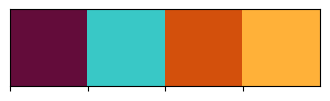

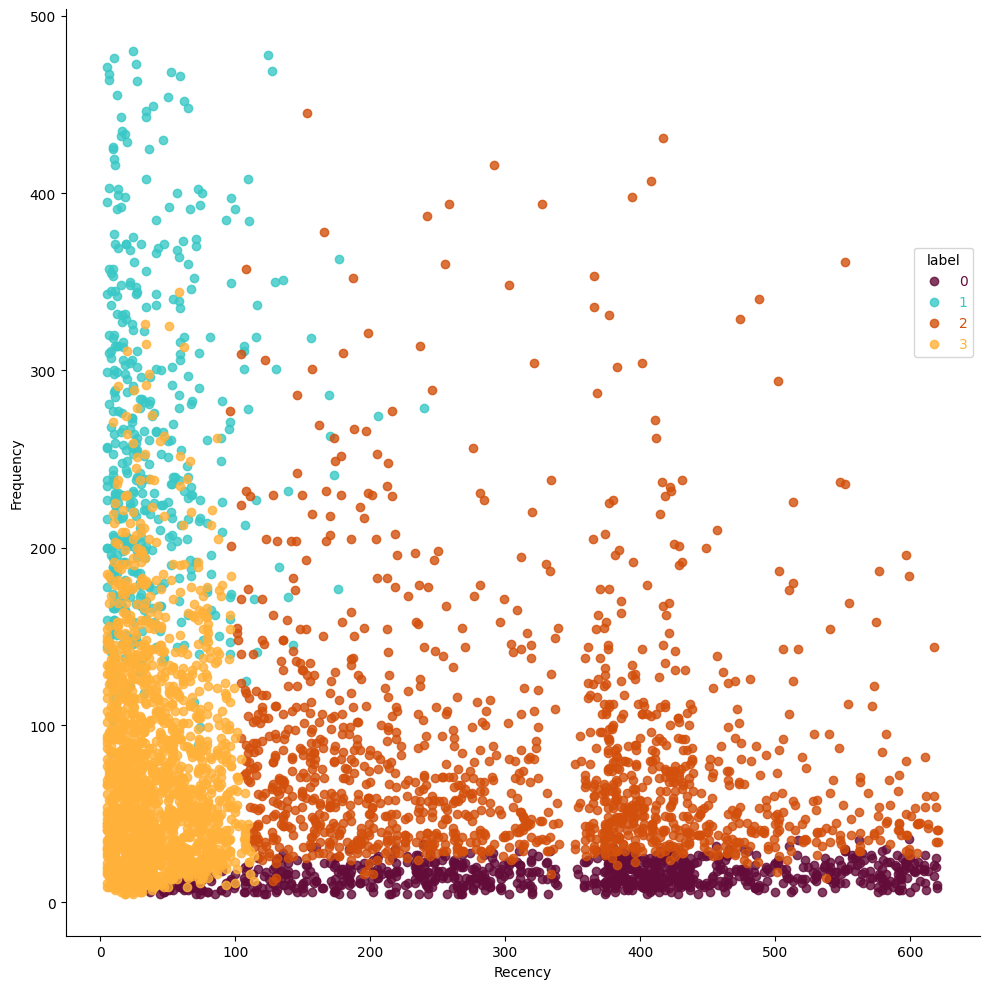

In [ ]:
#define a custom palette
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)

data = pd.DataFrame(data=rfm_fig,columns=['Customer ID','Cluster','Recency','Frequency','MonetaryValue'])

#plot data with seaborn (don't add a legend yet)
facet = sns.lmplot(data=data, x='Recency', y='Frequency', hue='Cluster', height=10,
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)
#change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

A high frequency is found with customers who have a recent purchase within a month.

# Frequency Vs Monetary

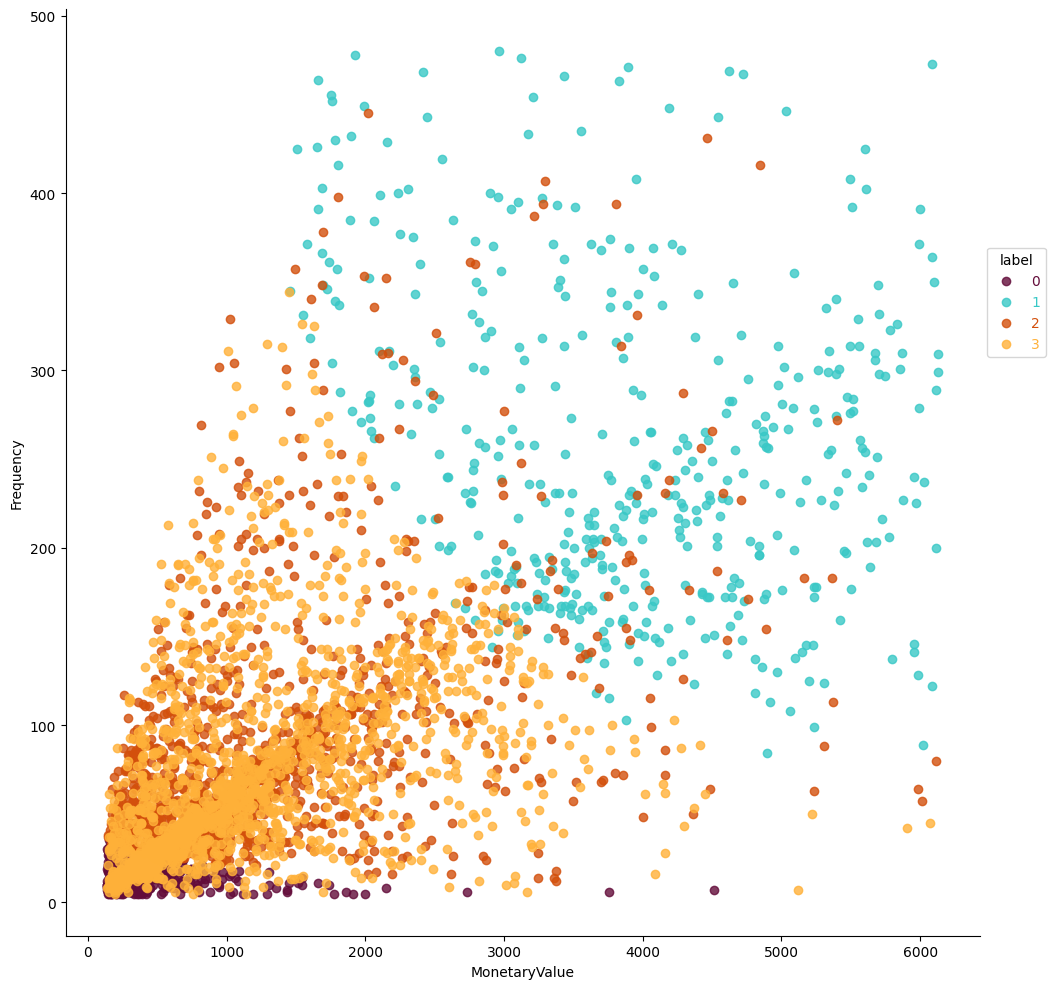

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 8))
#plot data with seaborn (don't add a legend yet)
facet = sns.lmplot(data=data, x='MonetaryValue', y='Frequency', hue='Cluster', height=10,
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)
#change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

Customers who buy frequently spend less money.

# Recency Vs Frequency Vs Monetary

In the above plot, the color specifies Cluster. From the above plot, we can see how the customers are spread among Recency, Frequency and Monetary dimension. Customers in Cluster 1 have made recent purchases with a high frequency, but with lower amounts. The reason for this could be that the customer frequently purchase Accessories that are not so expensive.

We can also use the following method to understand the relative importance of segments in the data. To do this, we will complete the following steps:

Calculate average values of each cluster
Calculate average values of population
Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)

In [ ]:
cluster_avg = rfm[['Cluster','Recency','Frequency','MonetaryValue']].groupby(['Cluster']).mean()
population_avg = rfm[['Recency','Frequency','MonetaryValue']].head().mean()

In [ ]:
cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,399.494652,12.683155,317.476404
1,36.739488,670.630713,14568.651076
2,333.461592,81.891061,1264.829920
3,38.352181,74.313947,1212.695220


As the final step in this analysis, we can extract this information now for each customer that can be used to map the customer with their relative importance by the company:

In [ ]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,1.72,-0.87,-0.98
1,-0.75,5.72,-0.18
2,1.27,-0.18,-0.93
3,-0.74,-0.26,-0.93


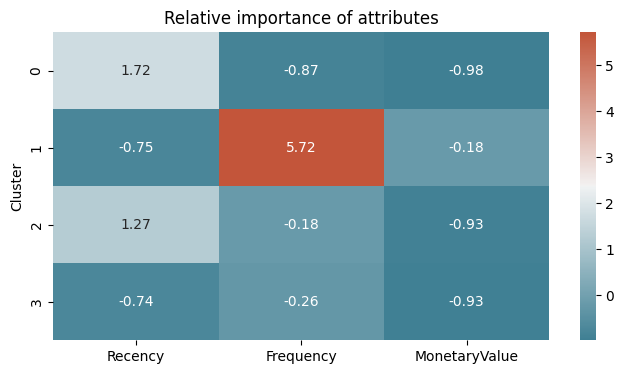

In [ ]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap=cmap)
plt.show()

# Interpret the result
From the above analysis, we can see that there should be 4 clusters in our data. To understand what these 4 clusters mean in a business scenario, we should look back the table comparing the clustering performance of 3 and 4 clusters for the mean values of recency, frequency, and monetary metric.

Below is the table giving the RFM interpretation of each segment and the points that a company is recommended to keep in mind while designing the marketing strategy for that segment of customers.
# Using the RFM segmentation to identify the type of customer according to RFM score
## Getting the individual RFM scores
Getting the individual RFM score can be done in several ways. You could use your own business expertise and heuristics to make rankings that suit your customer base. For this case, we are going to go the statistical route and rank our customer using quartiles.

The ranking of the individual RFM scores is done by dividing each of the RFM values into quartiles which creates four more or less equal buckets. We then rank each bucket from one to four; four being the best. Our summary table should now look something like this:

## Define quartiles for RFM score:


In [ ]:
# Create the quartiles scores
quantiles = rfm.quantile(q=[0.2,0.4,0.6,0.8])
quantiles = quantiles.to_dict()

def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]:
        return 3
    elif x <= d[p][0.8]:
        return 2
    else:
        return 1

def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]:
        return 3
    elif x <= d[p][0.8]:
        return 4
    else:
        return 5

rfm['R'] = rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm['F'] = rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm['M'] = rfm['MonetaryValue'].apply(FMScore, args=('MonetaryValue',quantiles,))

# Calculate the overall RFM score
This step can be done in two ways:

Concatenation: creates segments Here we just concatenate (not add) the individual RFM score like strings and get labeled segments in return. Our best segment will be 444 and our worst will be 111 — signifying the lowest score on all three of the RFM categories.

Addition: creates a score Here we add the individual RFM scores like numbers and get a number in return indicating the customer score. The score will range from 3 to 12 and we can use this to create more human friendly labelled categories.

In [ ]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(join_rfm, axis=1)
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

In [ ]:
rfm['RFM_Segment'].unique()


array(['225', '555', '334', '222', '444', '233', '223', '445', '455',
       '545', '322', '544', '112', '511', '123', '144', '522', '212',
       '245', '355', '344', '422', '234', '111', '454', '324', '133',
       '211', '413', '333', '533', '345', '244', '423', '411', '312',
       '122', '433', '323', '435', '523', '145', '121', '155', '534',
       '335', '113', '221', '432', '321', '332', '412', '134', '132',
       '311', '442', '535', '243', '235', '255', '532', '224', '143',
       '434', '343', '115', '342', '131', '512', '525', '214', '325',
       '443', '341', '554', '314', '514', '313', '421', '154', '524',
       '232', '231', '254', '242', '424', '543', '124', '513', '521',
       '114', '213', '354', '253', '441', '542', '142', '553', '431',
       '453', '353', '153', '331', '315', '135', '125', '425', '414',
       '352', '252', '515', '241', '215', '415', '452', '531'],
      dtype=object)

After calculations on the RFM data we can create customer segments that are actionable and easy to understand — like the ones below:

Champions: Bought recently, buy often and spend the most
Loyal customers: Buy on a regular basis. Responsive to promotions.
Potential loyalist: Recent customers with average frequency.
Recent customers: Bought most recently, but not often.
Promising: Recent shoppers, but haven’t spent much.
Needs attention: Above average recency, frequency and monetary values. May not have bought very recently though.
About to sleep: Below average recency and frequency. Will lose them if not reactivated.
At risk: Some time since they’ve purchased. Need to bring them back!
Can’t lose them: Used to purchase frequently but haven’t returned for a long time.
Hibernating: Last purchase was long back and low number of orders. May be lost.
# Grouping and labelling with RFM label
For the RFM segment we are going to use the most common naming scheme, as outlined above.

In [ ]:
# Create human friendly RFM labels
segt_map = {

    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At risk',
    r'[1-2]5': 'Can\'t lose them',
    r'3[1-2]': 'About to sleep',
    r'33': 'Need attention',
    r'[3-4][4-5]': 'Loyal customers',
    r'41': 'Promising',
    r'51': 'New customers',
    r'[4-5][2-3]': 'Potential loyalists',
    r'5[4-5]': 'Champions'
}
# rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)+ rfm['M'].map(str)
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
# Create some human friendly labels for the scores
rfm['Score'] = 'Green'
rfm.loc[rfm['RFM_Score']>5,'Score'] = 'Bronze'
rfm.loc[rfm['RFM_Score']>7,'Score'] = 'Silver'
rfm.loc[rfm['RFM_Score']>9,'Score'] = 'Gold'
rfm.loc[rfm['RFM_Score']>10,'Score'] = 'Platinum'
# List the head of the table to view the
rfm.head(5)

,Customer ID,Recency,Frequency,MonetaryValue,Cluster,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,12346.0,326,34,77556.46,1,2,2,5,225,9,Hibernating,Silver
1,12347.0,3,222,4921.53,1,5,5,5,555,15,Champions,Platinum
2,12348.0,76,51,2019.40,3,3,3,4,334,10,Need attention,Gold
3,12349.0,19,175,4428.69,1,5,5,5,555,15,Champions,Platinum
4,12350.0,311,17,334.40,0,2,2,2,222,6,Hibernating,Bronze


In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [ ]:
rfm.head()

,Customer ID,Recency,Frequency,MonetaryValue,Cluster,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,12346.0,326,34,77556.46,1,2,2,5,225,9,Hibernating,Silver
1,12347.0,3,222,4921.53,1,5,5,5,555,15,Champions,Platinum
2,12348.0,76,51,2019.40,3,3,3,4,334,10,Need attention,Gold
3,12349.0,19,175,4428.69,1,5,5,5,555,15,Champions,Platinum
4,12350.0,311,17,334.40,0,2,2,2,222,6,Hibernating,Bronze


In [ ]:
fig1 = rfm.groupby(['Segment']).count().unstack().fillna(0)
fig2 = rfm.groupby(['Score']).count().unstack().fillna(0)

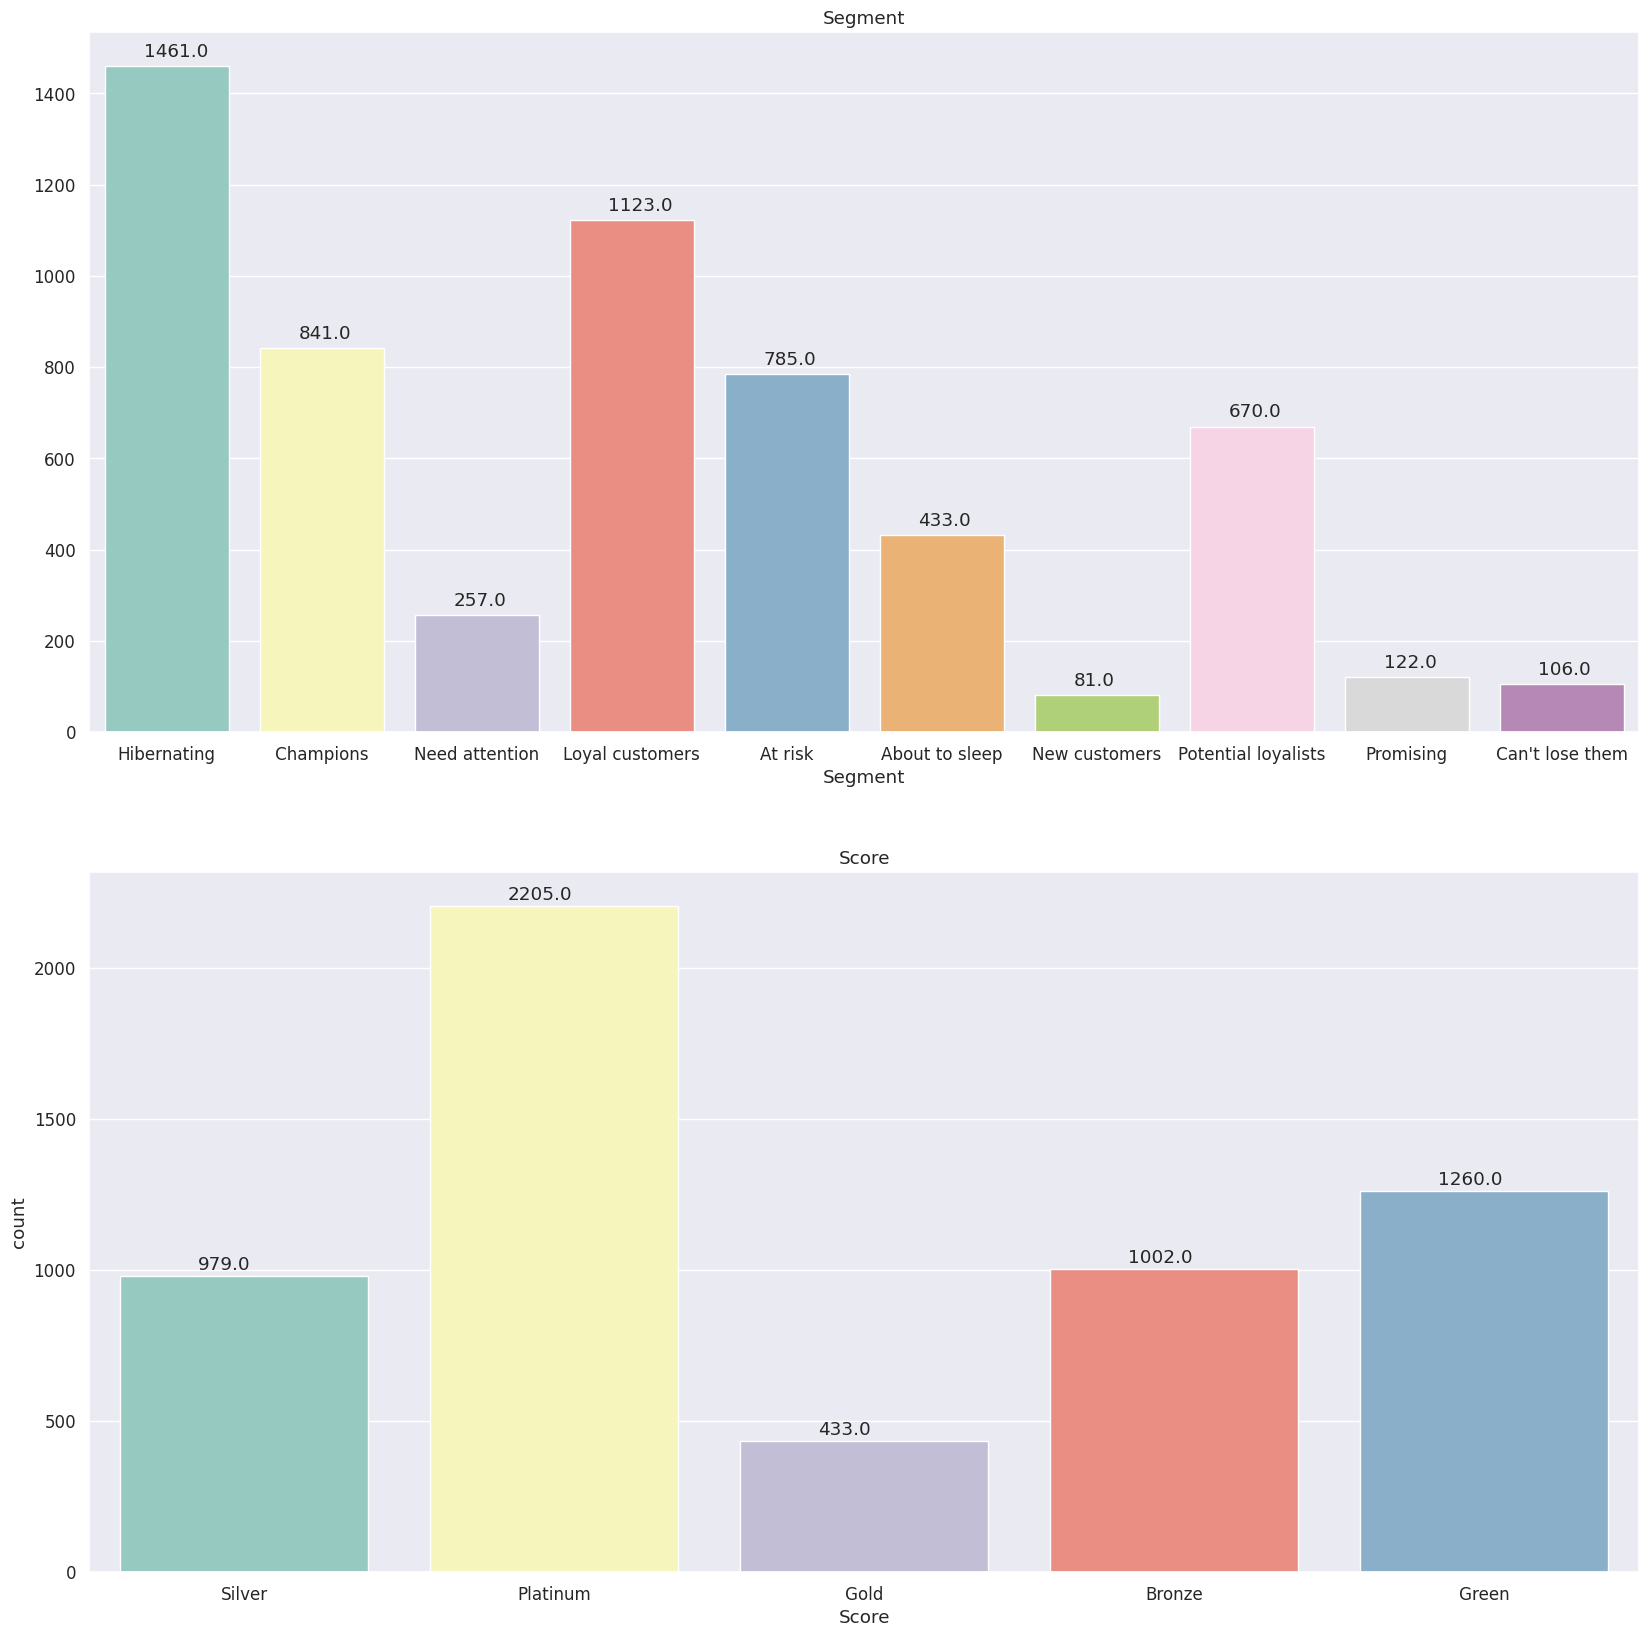

In [ ]:
# Pie Chart
f, ax = plt.subplots(2, 1, figsize=(20, 20))
sns.countplot(x='Segment', data=rfm, ax=ax[0], palette="Set3")
ax[0].set_title('Segment')
ax[0].set_ylabel('')

# Bar chart - count
sns.countplot(x='Score', data=rfm, ax=ax[1], palette="Set3")
ax[1].set_title('Score')

for p in ax[0].patches:
    ax[0].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+20))

for p in ax[1].patches:
    ax[1].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+20))

plt.show()


In [ ]:
# Aggregate data by each customer
fig3 = rfm.groupby('Segment').agg({'Customer ID': lambda x: len(x)}).reset_index()

# Rename columns
fig3.rename(columns={'Customer ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,Segment,Count,percent
0,About to sleep,433,7.4
1,At risk,785,13.4
2,Can't lose them,106,1.8
3,Champions,841,14.3
4,Hibernating,1461,24.9


In [ ]:
# Aggregate data by each customer
fig4 = rfm.groupby('Score').agg({'Customer ID': lambda x: len(x)}).reset_index()


# Rename columns
fig4.rename(columns={'Customer ID': 'Count'}, inplace=True)
fig4['percent'] = (fig4['Count'] / fig4['Count'].sum()) * 100
fig4['percent'] = fig4['percent'].round(1)

fig4.head()

,Score,Count,percent
0,Bronze,1002,17.0
1,Gold,433,7.4
2,Green,1260,21.4
3,Platinum,2205,37.5
4,Silver,979,16.7


In [ ]:
# colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c'] #color palette
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px
import plotly.offline as pyo

fig = px.treemap(fig4, path=['Score'], values='Count',
                 width=800, height=400,
                 title="Treemap of RFM Score",
                 color='Score',  # Specify a color parameter if needed
                 color_discrete_map={score: color for score, color in zip(fig4['Score'], colors)})

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25)
)

fig.data[0].textinfo = 'label+text+value+percent entry'

# Enable the rendering of Plotly visualizations in Colab
pyo.iplot(fig)



# Using RFM segment to Interpret the result

In [ ]:
# Aggregate data by each customer
rfm1 = rfm.groupby(['Cluster','Segment'],).agg({'Customer ID': lambda x: len(x)}).reset_index()

# Rename columns
rfm1.rename(columns={'Customer ID': 'Count'}, inplace=True)
rfm1['percent'] = (rfm1['Count'] / rfm1.groupby('Cluster')['Count'].transform('sum')) * 100
rfm1['percent'] = rfm1['percent'].round(1)

rfm1Step 4 Action to take for retain the customer
Here's a handy chart of all the RFM Segments, and some actionable tips for each which can implement straight away!

What we have learned



,Cluster,Segment,Count,percent
0,0,About to sleep,222,14.8
1,0,At risk,1,0.1
2,0,Hibernating,1225,81.9
3,0,New customers,6,0.4
4,0,Promising,42,2.8
5,1,About to sleep,2,0.2
6,1,At risk,5,0.5
7,1,Can't lose them,18,1.6
8,1,Champions,567,51.8
9,1,Hibernating,2,0.2


# Step 4 Action to take for retain the customer
Here's a handy chart of all the RFM Segments, and some actionable tips for each which can implement straight away!

What we have learned

